In [ ]:
import autograd.numpy as np
import autograd.numpy.random as npr
npr.seed(0)

import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

%matplotlib inline

import seaborn as sns

sns.set_style("white")
sns.set_context("talk")

color_names = ["windows blue",
               "red",
               "amber",
               "faded green",
               "dusty purple",
               "orange",
               "clay",
               "pink",
               "greyish",
               "mint",
               "cyan",
               "steel blue",
               "forest green",
               "pastel purple",
               "salmon",
               "dark brown"]

colors = sns.xkcd_palette(color_names)
cmap = ListedColormap(colors)

import ssm
from ssm.util import random_rotation, find_permutation
from ssm.plots import plot_dynamics_2d

save_figures = False

## Synthetic SLDS with ECoG-like dimensions

In [17]:
# Set the parameters of the SLDS
time_bins = 10000    # number of time bins
n_disc_states = 3 # As described in Amir's script tasks = ["AudRep", "PicN", "VisRead"]
latent_dim = 2 # latent dimensions
n_elec = 128 # 128 elecrodes(emissions_dimesnion)

slds = ssm.SLDS(n_elec,
                n_disc_states,
                latent_dim,
                emissions = "gaussian_orthog")
z_true, x_true, y = slds.sample(time_bins)
# print(f"States_z: {z_true}")
# print(f"\nStates_x: {x_true}")
# print(f"\nemissions: {y}")

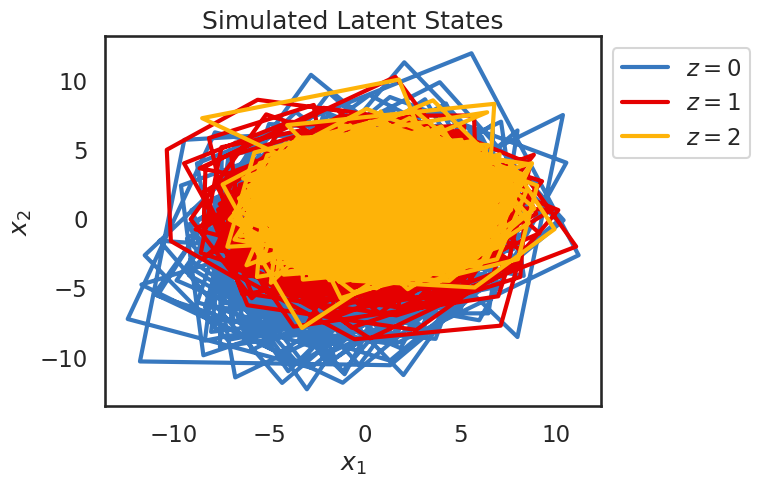

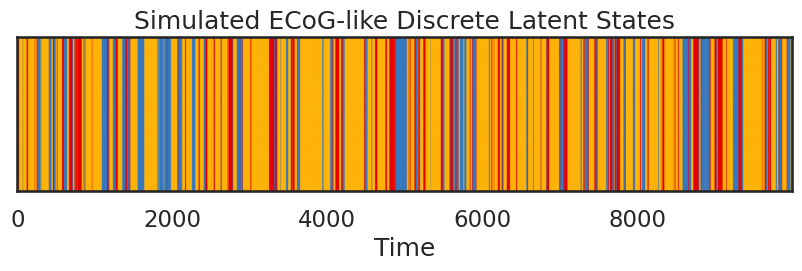

In [18]:
for k in range(n_disc_states):
    curr_states = x_true[z_true == k]
    plt.plot(curr_states[:,0],
             curr_states[:,1],
             '-',
             color=colors[k],
             lw=3,
             label="$z=%i$" % k)
    
    # Draw lines connecting the latent state between discrete state transitions,
    # so they don't show up as broken lines.
    next_states = x_true[z_true == k + 1]
    if len(next_states) > 0 and len(curr_states) > 0:
        plt.plot((curr_states[-1,0], next_states[0,0]),
                 (curr_states[-1,1], next_states[0,1]),
                 '-',
                 color='gray',
                 lw=1)

plt.xlabel("$x_1$")
plt.ylabel("$x_2$")
plt.title("Simulated Latent States")
plt.legend(bbox_to_anchor=(1.0,1.0))
plt.show()

plt.figure(figsize=(10,2))
cmap_limited = ListedColormap(colors[0:n_disc_states])
plt.imshow(z_true[None,:],  aspect="auto", cmap=cmap_limited)
plt.title("Simulated ECoG-like Discrete Latent States")
plt.yticks([])
plt.xlabel("Time")
plt.show()

## Fit a new SLDS to the observation(ECoG) data

In [19]:
ecog_like_slds = ssm.SLDS(n_elec,
                    n_disc_states,
                    latent_dim,
                    emissions = "gaussian_orthog")
elbos, posterior = ecog_like_slds.fit(y, 
                                      method = "laplace_em", 
                                      variational_posterior = "structured_meanfield",
                                      num_iters = 100)

# Get the posterior mean of the continuous state
elbos_x = posterior.mean_continuous_states[0]
print(elbos_x.shape)

# Find the permutation that matches the true and inferred states
ecog_like_slds.permute(find_permutation(z_true, ecog_like_slds.most_likely_states(elbos_x, y)))
elbos_z = ecog_like_slds.most_likely_states(elbos_x, y)

elbos_y = ecog_like_slds.smooth(elbos_x, y)

  0%|          | 0/1 [00:00<?, ?it/s]

Initializing with an ARHMM using 25 steps of EM.


  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

(10000, 2)


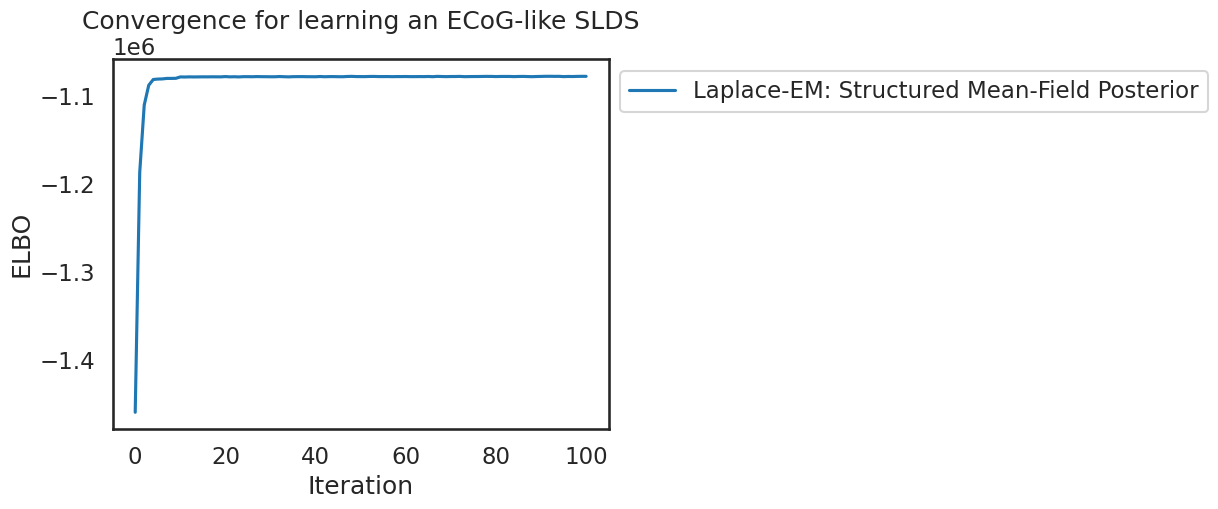

In [20]:
# Plot the ELBOs
plt.plot(elbos, label="Laplace-EM: Structured Mean-Field Posterior")
plt.xlabel("Iteration")
plt.ylabel("ELBO")
plt.legend(bbox_to_anchor=(1.0,1.0))
plt.title("Convergence for learning an ECoG-like SLDS")
plt.show()

## Visualize True and Inferred Latent States

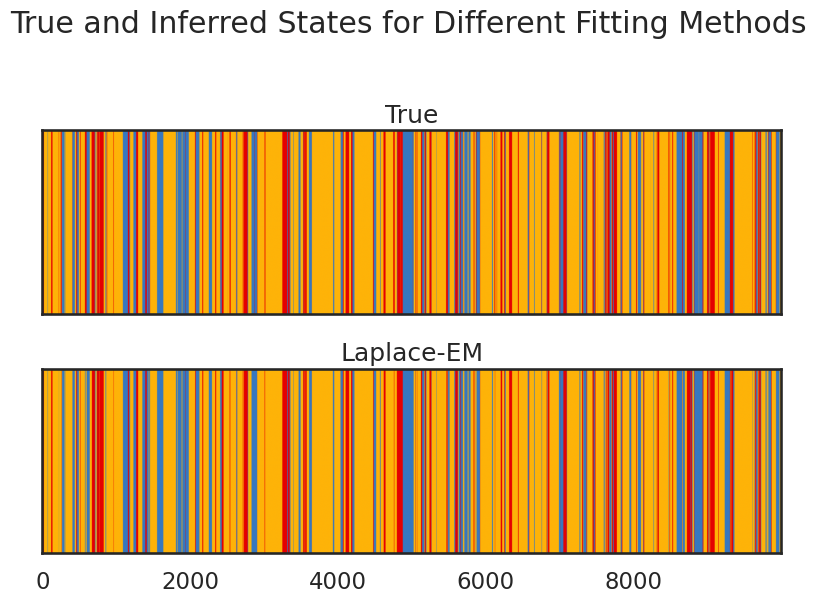

In [21]:
# Plot the true and inferred states
titles = ["True", "Laplace-EM",]
states_list = [z_true, elbos_z]
fig, axs = plt.subplots(2,1, figsize=(8,6))
for (i, ax, states) in zip(range(len(axs)), axs, states_list):
    ax.imshow(states[None,:], aspect="auto", cmap=cmap_limited)
    ax.set_yticks([])
    ax.set_title(titles[i])
    if i < (len(axs) - 1):
        ax.set_xticks([])

plt.suptitle("True and Inferred States for Different Fitting Methods", va="baseline")
plt.tight_layout()

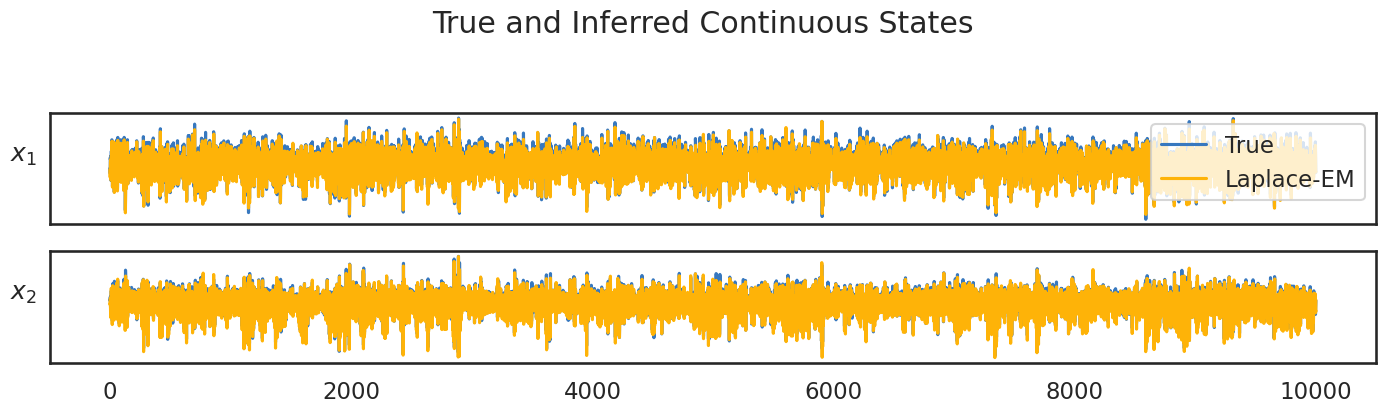

In [22]:
title_str = ["$x_1$", "$x_2$"]
fig, axs = plt.subplots(2,1, figsize=(14,4))
for (d, ax) in enumerate(axs):
    ax.plot(x_true[:,d] + 4 * d, '-', color=colors[0], label="True" if d==0 else None)
    ax.plot(elbos_x[:,d] + 4 * d, '-', color=colors[2], label="Laplace-EM" if d==0 else None)
    ax.set_yticks([])
    ax.set_title(title_str[d], loc="left", y=0.5, x=-0.03)
axs[0].set_xticks([])
axs[0].legend(loc="upper right")

plt.suptitle("True and Inferred Continuous States", va="bottom")
plt.tight_layout()